In [2]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

# https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

12089


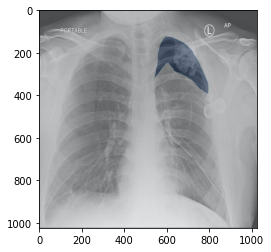

In [3]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
file_ImageId_path = []
for root, dir_, files in os.walk("dicom-images-train"):
    for file in files:
        if file.endswith(".dcm"):
            file_ImageId_path.append([os.path.splitext(file)[0], os.path.join(root, file)])
print(len(file_ImageId_path))           
# df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])

df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])
df_files
df_siim = pd.read_csv("train-rle.csv")
df_siim_file = pd.merge(df_siim, df_files, on="ImageId")
case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[1]]
dcm = pydicom.dcmread(case1.filepath.values.tolist()[0])
img = dcm.pixel_array
height, width = img.shape
mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0], width, height)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.3)

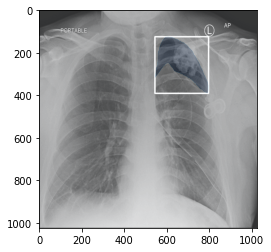

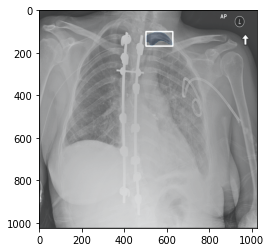

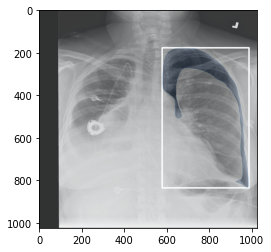

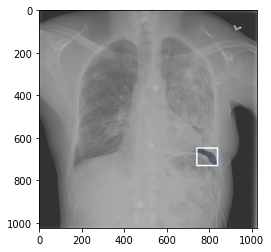

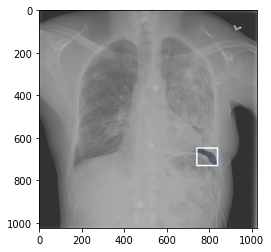

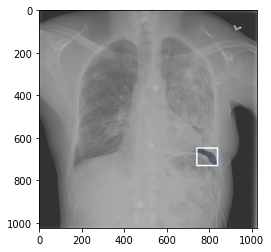

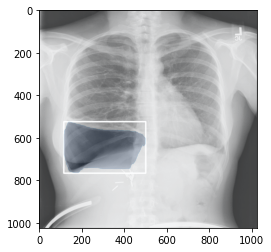

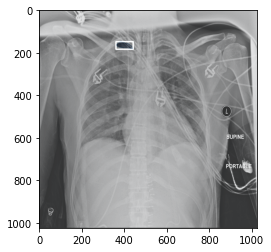

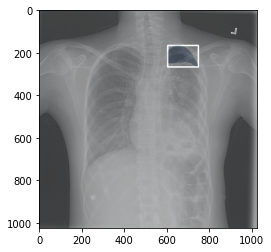

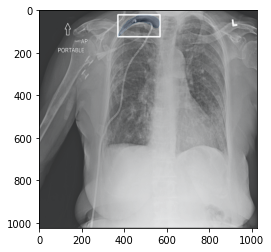

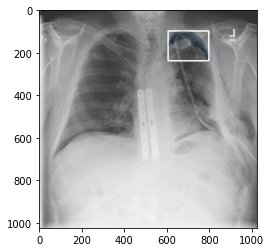

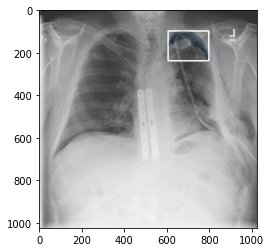

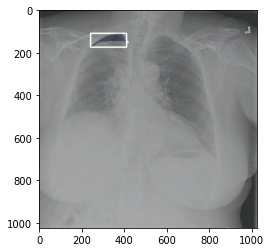

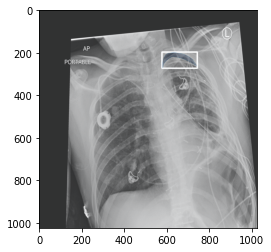

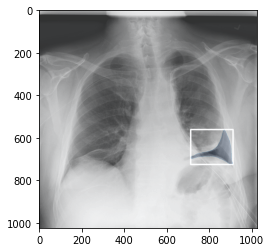

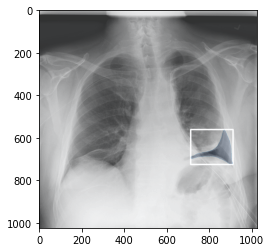

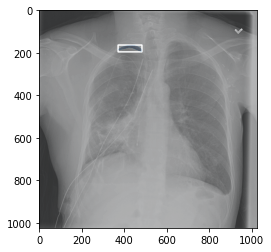

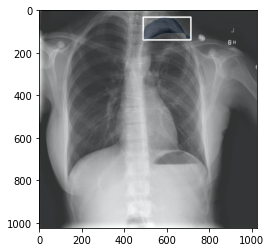

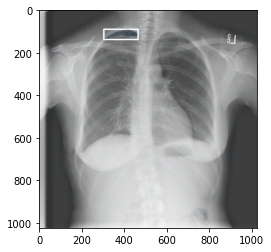

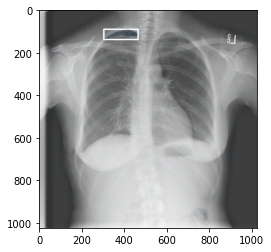

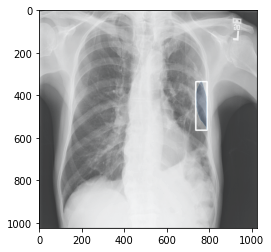

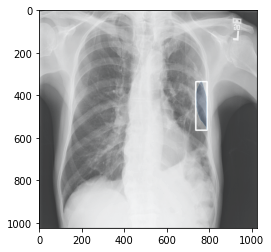

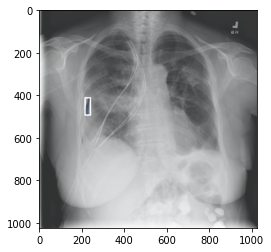

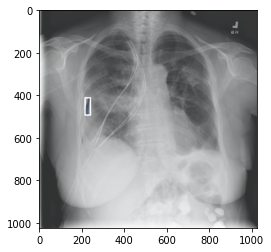

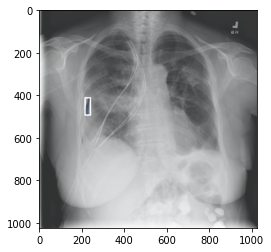

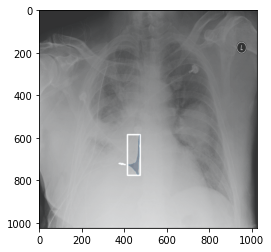

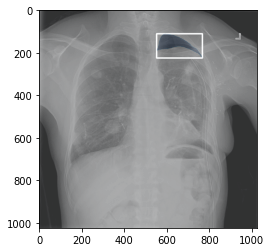

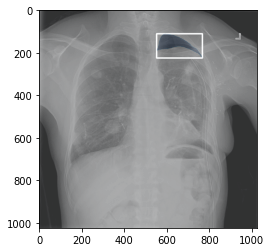

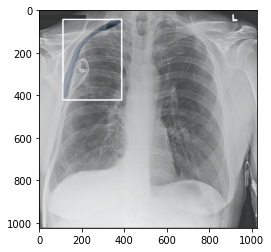

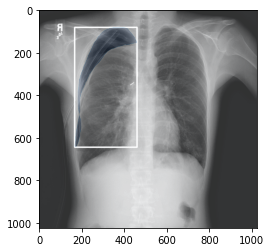

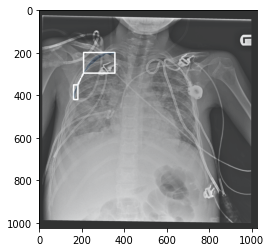

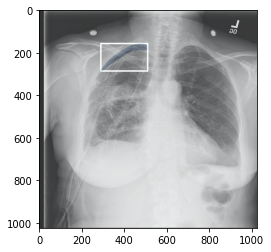

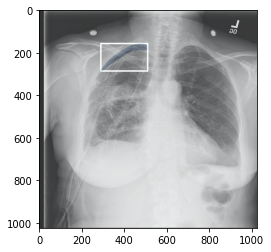

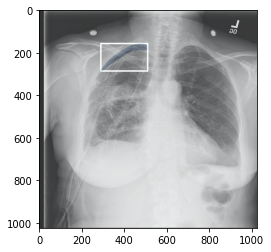

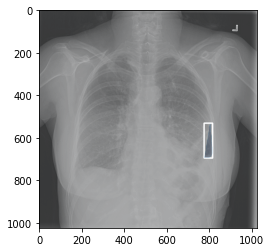

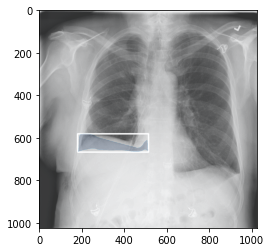

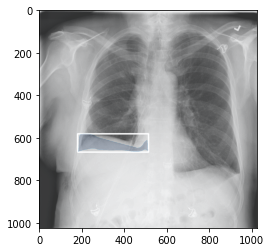

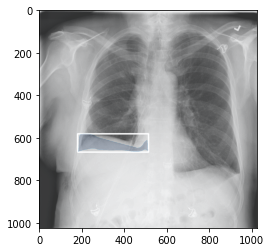

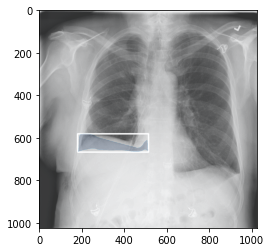

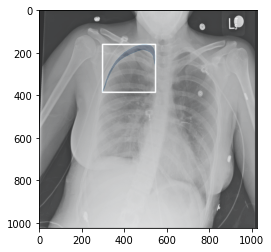

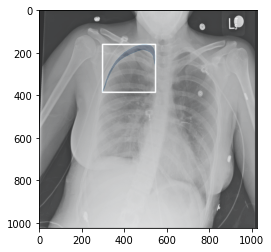

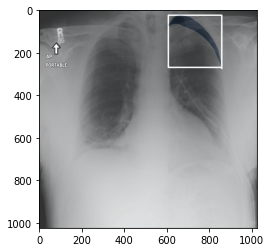

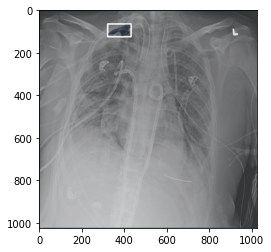

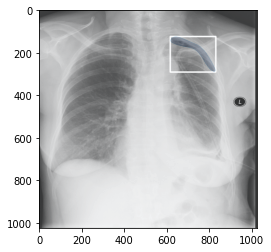

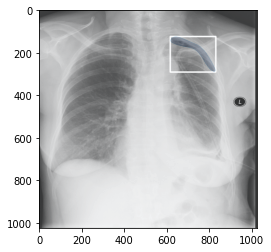

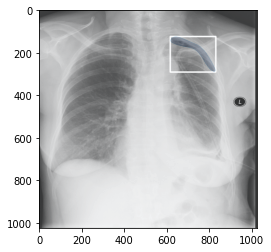

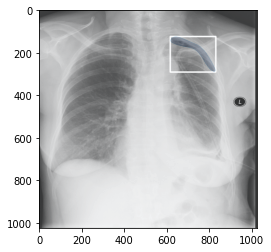

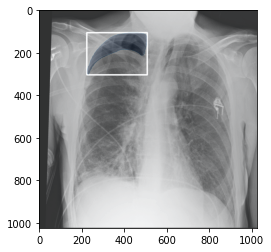

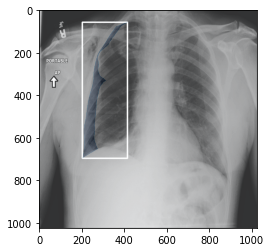

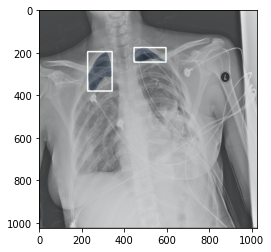

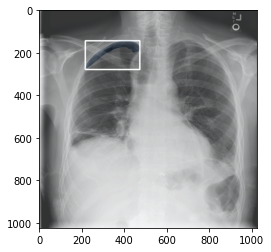

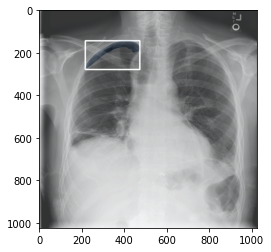

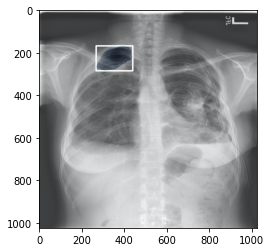

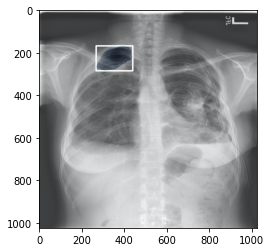

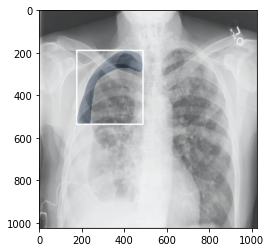

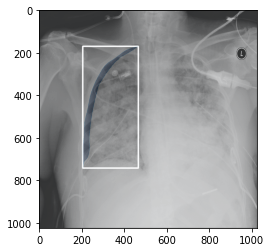

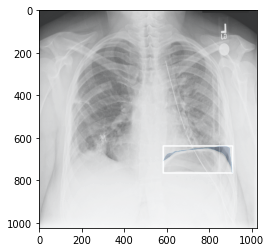

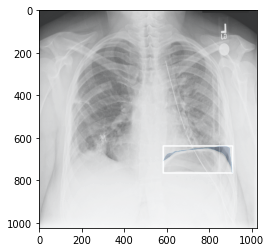

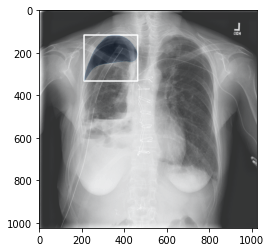

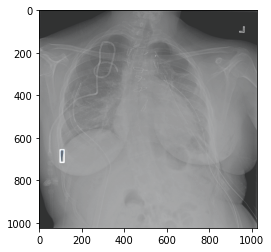

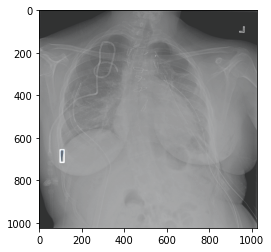

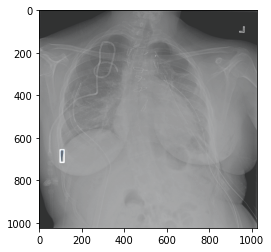

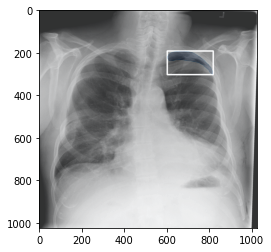

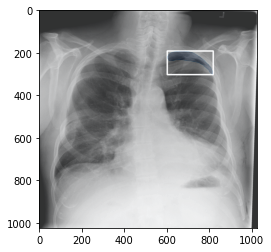

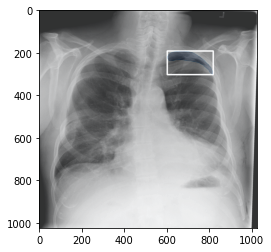

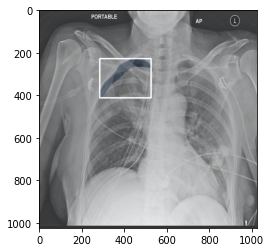

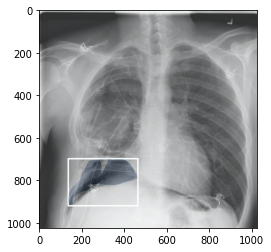

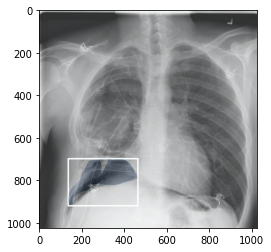

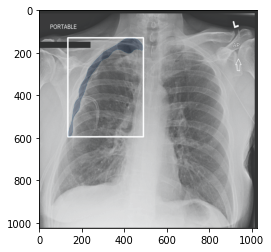

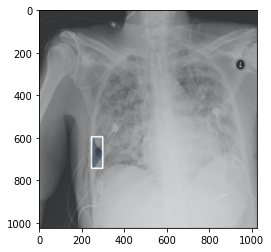

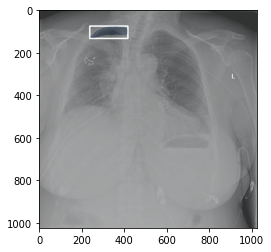

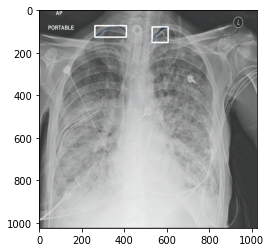

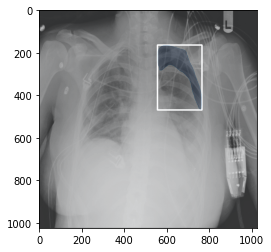

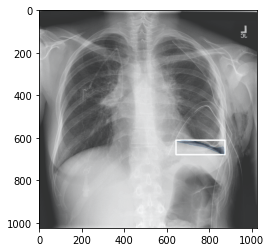

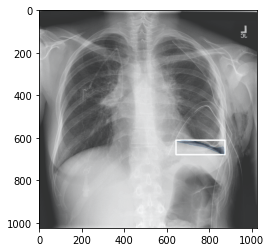

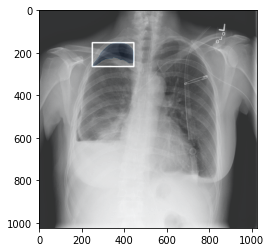

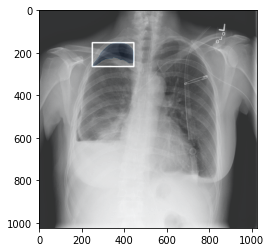

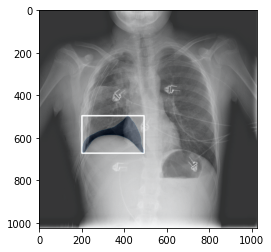

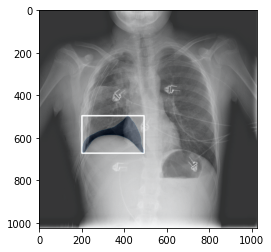

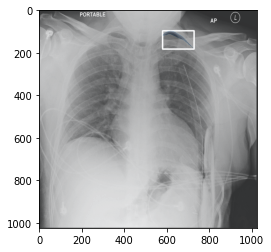

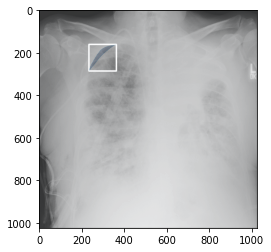

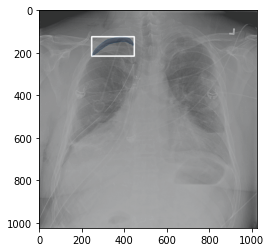

In [4]:
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
import cv2

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


for i in range(200):
    
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    height, width = img.shape
    
    
    if not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        
    
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask) 
        props = regionprops(lbl_0)
        for prop in props:
#             print(prop.bbox[1])
#             print(prop.bbox[0])
#             print('----')
#             print(prop.bbox[3])
#             print(prop.bbox[2])
            cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 255, 255), 5)
            
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
#             print(bb)
#             x = bb[0]
#             y = bb[1]
#             w = bb[2]
#             h = bb[3]
#             dw = 1024
#             dh = 1024
            
#             l = int((x - w / 2) * dw)
#             r = int((x + w / 2) * dw)
#             t = int((y - h / 2) * dh)
#             b = int((y + h / 2) * dh)
            
#             if l < 0:
#                 l = 0
#             if r > dw - 1:
#                 r = dw - 1
#             if t < 0:
#                 t = 0
#             if b > dh - 1:
#                 b = dh - 1

#             cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

        
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='Blues', alpha=0.2)
        plt.show()

# prepare data for yolo
- images: dicom to jpg
- annotations: cover bounding box to yolo formate

In [5]:
from tqdm import tqdm
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
from skimage import data,segmentation,measure,morphology,color
import cv2
import shutil
import matplotlib.pyplot as plt

dicom_path = './dicom-images-train'
save_jpg_path = './images'
annotations_path ='./annotations'

def create_dir(dir_path: str, ifdelete: bool = False) -> None:
    '''
    check if dir exists, creat dir if not.
    iddelete is True, remove dir if exists, else pass.
    '''

    if os.path.isdir(dir_path):
        if ifdelete:
            shutil.rmtree(dir_path)
            os.makedirs(dir_path)
    else :
        os.makedirs(dir_path)

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


create_dir(save_jpg_path,ifdelete = True)
create_dir(annotations_path,ifdelete = True)


# for i in range(10):
for i in tqdm(range(len(df_siim_file['ImageId']))):
    
    # jpg
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    cv2.imwrite(os.path.join(save_jpg_path,df_siim_file['ImageId'][i]+'.jpg'), img)
    
    
    # label
    if (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        with open(os.path.join(annotations_path,df_siim_file['ImageId'][i]+'.txt'),'w') as f:
            pass
        
    elif not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask) 
        
        
        # 忽略小區域
        for region in measure.regionprops(lbl_0):
            if region.area < 100:
                continue
            
            else :
                
        
        
                props = regionprops(lbl_0)
                for prop in props:
                    b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
                    bb = convert_boundingbox_to_yolo_formate((1024,1024), b)

                    with open(os.path.join(annotations_path,df_siim_file['ImageId'][i]+'.txt'),'a+') as f:
                        f.write('0'+'\t'+str(bb[0])+'\t'+str(bb[1])+'\t'+str(bb[2])+'\t'+str(bb[3])+'\t'+'\n')
                        f.close()
    
#     break

print('len images',len(os.listdir(save_jpg_path)))
print('len annotation',len(os.listdir(annotations_path)))
    

 10%|▉         | 1241/12954 [00:30<04:44, 41.18it/s]


KeyboardInterrupt: 

In [ ]:
print('len images',len(os.listdir(save_jpg_path)))
print('len annotation',len(os.listdir(annotations_path)))

In [125]:
12047 - 9378

2669

# 檢查一張圖片多處氣胸

- 氣胸的數量: 2669
- 沒氣胸的數量: 9378

## 氣胸 box數量: 圖片總數
- 0: 9378
- 1: 3149
- 2: 231
- 3: 85
- 4: 32
- 5: 35
- 6: 12
- 9: 10
- 7: 8
- 8: 7
- 10: 3
- 11: 3
- 20: 1

In [59]:
from tqdm import tqdm
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
import cv2

dicom_path = './dicom-images-train'
save_jpg_path = './images'
annotations_path ='./annotations'

index_box =[]
box_len_list = []

index_area = []
area_list = []
c_no_pneumothorax = 0


def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

# for i in range(1000):
for i in tqdm(range(len(df_siim_file['ImageId']))):
    
    # jpg
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    cv2.imwrite(os.path.join(save_jpg_path,df_siim_file['ImageId'][i]+'.jpg'), img)
    
    
    # label
    if (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        box_len_list.append(0)
        
        index_area.append(i)
#         area_list.append(0)
        c_no_pneumothorax += 1
        pass
        
    elif not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        
        lbl_0 = label(mask) 
        props = regionprops(lbl_0)
        box_len_list.append(len(props))
        for prop in props:
            
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
            area = abs(prop.bbox[1] - prop.bbox[3])* abs(prop.bbox[0] - prop.bbox[2])
            
            index_area.append(i)
            area_list.append(area)

print('finish') 

print()

100%|██████████| 12954/12954 [03:19<00:00, 64.84it/s]

finish



In [60]:
print('box_len_list',len(box_len_list))
print('area_list',len(area_list))
print('no_pneumothorax',c_no_pneumothorax)

box_len_list 12954
area_list 4526
no_pneumothorax 9378


Counter({0: 9378, 1: 3149, 2: 231, 3: 85, 5: 35, 4: 32, 6: 12, 9: 10, 7: 8, 8: 7, 10: 3, 11: 3, 20: 1})


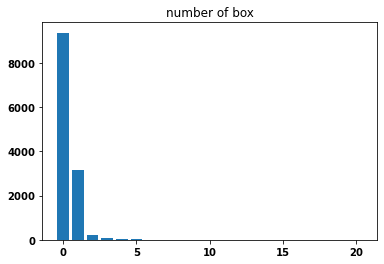

In [142]:
import matplotlib.pyplot as plt
from collections import Counter

c = Counter(box_len_list)
sorted(c.items())
print(c)

plt.title('number of box') 
plt.bar(c.keys(), c.values())
plt.show()


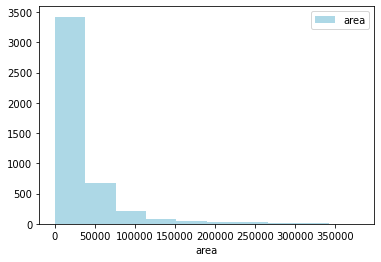

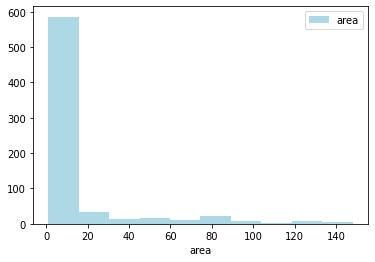

150

In [102]:
plt.hist(area_list, density=False, color = 'lightblue', cumulative = False, label = "area")
plt.legend()
plt.xlabel('area')
plt.show()

# sorted(area_list)
sorted(area_list)[1800]
area_list_700 = sorted(area_list)[0:700]

plt.hist(area_list_700, density=False, color = 'lightblue', cumulative = False, label = "area")
plt.legend()
plt.xlabel('area')
plt.show()

sorted(area_list)[700]

# 檢查面積小的區塊排除小面積 (設定 50 )

77
20


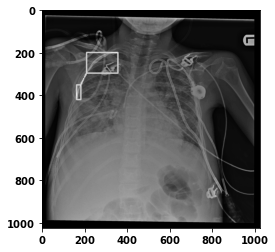

In [122]:
# 20
num = 20
index_list = [i for i, e in enumerate(box_len_list) if e == num]
index_list

# plot
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
import cv2

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


for i in range(len(index_list)):
    
    print(index_list[i])
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[index_list[i]]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    height, width = img.shape
    
    
    if not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        
    
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask) 
        props = regionprops(lbl_0)
        print(len(props))
        for prop in props:
            cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 255, 255), 5)
            
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
        
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='gray', alpha=0.2)
        plt.show()
        plt.imsave('./data_review/'+str(num)+'_'+str(index_list[i])+'.jpg',img,cmap='gray')

# 計算  box 面積

5197
(244, 454, 152, 279)
(242, 243, 281, 282)
(238, 242, 283, 287)
(236, 237, 289, 290)
(218, 236, 291, 316)
(216, 217, 318, 319)
(212, 216, 320, 326)
(211, 212, 327, 328)
(210, 211, 329, 330)
(208, 212, 331, 335)


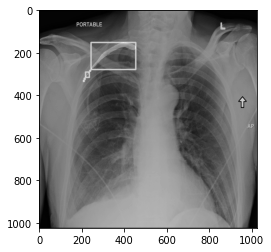

7909
(692, 816, 569, 674)
(689, 690, 588, 589)
(686, 687, 589, 590)
(674, 680, 591, 593)
(671, 672, 593, 594)
(668, 669, 594, 595)
(665, 666, 595, 596)
(662, 663, 596, 597)
(656, 657, 598, 599)
(567, 651, 600, 641)


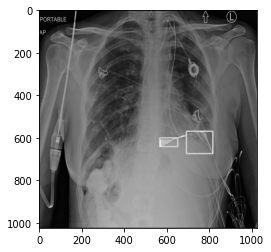

7910
(692, 816, 569, 674)
(689, 690, 588, 589)
(686, 687, 589, 590)
(674, 680, 591, 593)
(671, 672, 593, 594)
(668, 669, 594, 595)
(665, 666, 595, 596)
(662, 663, 596, 597)
(656, 657, 598, 599)
(567, 651, 600, 641)


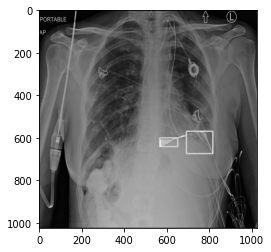

In [112]:
num = 10
index_list = [i for i, e in enumerate(box_len_list) if e == num]
index_list

# plot
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
from skimage import data,segmentation,measure,morphology,color
import cv2

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


for i in range(len(index_list)):
    
    print(index_list[i])
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[index_list[i]]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    height, width = img.shape
    
    
    if not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        
    
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask)
        
#         print('measure.regionprops(lbl_0)',measure.regionprops(lbl_0))
        
        
        
        '''
        props = regionprops(lbl_0)
        for prop in props:
            cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 255, 255), 5)
            area = abs(prop.bbox[1] - prop.bbox[3])* abs(prop.bbox[0] - prop.bbox[2])
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            print('area: ',area)
        
        '''
#         # 忽略小區域
        for region in measure.regionprops(lbl_0):
            print('region.area',region.area)
            if region.area < 20:
                continue
                
#             else:
        
#                 props = regionprops(lbl_0)
#                 for prop in props:
#                     cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 255, 255), 5)
#                     area = abs(prop.bbox[1] - prop.bbox[3])* abs(prop.bbox[0] - prop.bbox[2])
#                     b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
#                     print('area: ',area)


                    cv2.rectangle(img, (region.bbox[1], region.bbox[0]), (region.bbox[3], region.bbox[2]), (255, 255, 255), 5)
                    b = (region.bbox[1], region.bbox[3], region.bbox[0], region.bbox[2])
                    print(b)

                    bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
        
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='gray', alpha=0.2)
        plt.show()
        plt.imsave('./data_review/'+'passsmallarea'+str(num)+'_'+str(index_list[i])+'.jpg',img,cmap='gray')

In [63]:
# 忽略小區域 存 image and label fix bug
# 2021-08-26
import os
from tqdm import tqdm
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
from skimage import data,segmentation,measure,morphology,color
import cv2
import shutil
import matplotlib.pyplot as plt

dicom_path = './dicom-images-train'
save_jpg_path = './images'
annotations_path ='./labels'

def create_dir(dir_path: str, ifdelete: bool = False) -> None:
    '''
    check if dir exists, creat dir if not.
    iddelete is True, remove dir if exists, else pass.
    '''

    if os.path.isdir(dir_path):
        if ifdelete:
            shutil.rmtree(dir_path)
            os.makedirs(dir_path)
    else :
        os.makedirs(dir_path)

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


create_dir(save_jpg_path,ifdelete = True)
create_dir(annotations_path,ifdelete = True)


# unique image id list
unique_image_id_list = list(set(df_siim_file['ImageId'].tolist()))

# for i in range(10):
for image_id in tqdm(unique_image_id_list):
    
    # jpg
    case1 = df_siim_file[df_siim_file.ImageId==image_id]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    cv2.imwrite(os.path.join(save_jpg_path,image_id+'.jpg'), img)

    # label
    if (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        with open(os.path.join(annotations_path,image_id+'.txt'),'w') as f:
            pass

    elif not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        for rle in case1[' EncodedPixels'].values.tolist():
            mask = rle2mask(rle,  height, width)
            lbl_0 = label(mask) 


            # 忽略小區域
            for region in regionprops(lbl_0):
                if region.area < 50:
                    continue
                else :
                    b = (region.bbox[1], region.bbox[3], region.bbox[0], region.bbox[2])
                    bb = convert_boundingbox_to_yolo_formate((1024,1024), b)

                    with open(os.path.join(annotations_path,image_id+'.txt'),'a+') as f:
                        f.write('0'+'\t'+str(bb[0])+'\t'+str(bb[1])+'\t'+str(bb[2])+'\t'+str(bb[3])+'\t'+'\n')
                        f.close()

print('len images',len(os.listdir(save_jpg_path)))
print('len annotation',len(os.listdir(annotations_path)))
    

100%|██████████| 12047/12047 [03:07<00:00, 64.32it/s]

len images 12047
len annotation 12047


# 分割 train data/ val data

In [85]:
# train:val = 0.8:0.1
import os
import shutil
from sklearn.model_selection import train_test_split

def create_dir(dir_path: str, ifdelete: bool = False) -> None:
    '''
    check if dir exists, creat dir if not.
    iddelete is True, remove dir if exists, else pass.
    '''

    if os.path.isdir(dir_path):
        if ifdelete:
            shutil.rmtree(dir_path)
            os.makedirs(dir_path)
    else :
        os.makedirs(dir_path)

images_path = './images'
labels_path = './labels'

# create dir
create_dir('./train/',ifdelete = True)
create_dir('./train/images',ifdelete = True)
create_dir('./train/labels',ifdelete = True)
create_dir('./val/',ifdelete = True)
create_dir('./val/images',ifdelete = True)
create_dir('./val/labels',ifdelete = True)


# split train val
images_list = sorted(os.listdir(images_path))
labels_list = sorted(os.listdir(labels_path))

train_images, val_images = train_test_split(images_list, random_state=777, train_size=0.8)
train_labels, val_labels = train_test_split(labels_list, random_state=777, train_size=0.8)

# copy to train
for train_image in train_images:
    shutil.copyfile(os.path.join(images_path,train_image),os.path.join('./train/images',train_image))
    
for train_label in train_labels:
    shutil.copyfile(os.path.join(labels_path,train_label),os.path.join('./train/labels',train_label))
    
for val_image in val_images:
    shutil.copyfile(os.path.join(images_path,val_image),os.path.join('./val/images',val_image))
    
for val_label in val_labels:
    shutil.copyfile(os.path.join(labels_path,val_label),os.path.join('./val/labels',val_label))    
    
print('finish')    

finish


In [86]:
print(len(os.listdir('./train/images')))
print(len(os.listdir('./train/labels')))

print(len(os.listdir('./val/images')))
print(len(os.listdir('./val/labels')))

9637
9637
2410
2410
